# 分类模型构建与评估

In [121]:
# 导入基础数据处理库
import pandas as pd
import numpy as np

# 模型相关库（sklearn）
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
XGB_IMPORTED = True


# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 中文显示设置
FONT_TO_USE = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = [FONT_TO_USE]
plt.rcParams['axes.unicode_minus'] = False


# 设置 Seaborn 风格
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.3,
    font=FONT_TO_USE,
)

# 特征名映射
feature_name_map_zh = {
    'culmen_length_mm': '喙长 (mm)',
    'culmen_depth_mm': '喙深 (mm)',
    'flipper_length_mm': '鳍状肢长 (mm)',
    'body_mass_g': '体重 (g)',
    'culmen_ratio': '喙长宽比',
    'body_mass_kg': '体重 (kg)',
    'island_encoded': '岛屿 (编码)',
    'sex_zh_encoded': '性别 (编码)',
    'species_zh_encoded': '种类 (编码)'
}

In [122]:
# 读取上一步保存的文件
df = pd.read_csv('penguins_ml_processed.csv')

if not df.empty:
    print("数据集维度：", df.shape)
    print("\n数据集前3行（已标准化和编码）：")
    print(df.head(3))

数据集维度： (333, 16)

数据集前3行（已标准化和编码）：
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen         -0.896042         0.780732          -1.426752   
1  Adelie  Torgersen         -0.822788         0.119584          -1.069474   
2  Adelie  Torgersen         -0.676280         0.424729          -0.426373   

   body_mass_g     sex  culmen_ratio  body_mass_kg species_zh sex_zh  \
0    -0.568475    MALE     -1.043718     -0.568475      阿德利企鹅    男企鹅   
1    -0.506286  FEMALE     -0.681461     -0.506286      阿德利企鹅    女企鹅   
2    -1.190361  FEMALE     -0.744583     -1.190361      阿德利企鹅    女企鹅   

   species_encoded  island_encoded  sex_encoded  species_zh_encoded  \
0                0               2            1                   2   
1                0               2            0                   2   
2                0               2            0                   2   

   sex_zh_encoded  
0               1  
1               0  
2               0 

# 任务一：企鹅种类预测（多分类）

In [123]:
# 种类预测 - 准备数据
print("任务一：企鹅种类预测")

# 步骤1：特征集 (X) 和目标变量 (y)
# 特征集：使用所有标准化数值特征 + 岛屿编码 + 性别编码
feature_cols_species = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
    'body_mass_g', 'culmen_ratio', 'body_mass_kg',
    'island_encoded', 'sex_zh_encoded'
]

target_col_species = 'species_zh'  # 把目标指向中文种类
target_col_species_encoded = 'species_zh_encoded'  # 把目标指向中文种类编码

X_species = df[feature_cols_species]
y_species = df[target_col_species_encoded]

# 获取图表的中文标签
species_labels_df = df[[target_col_species_encoded, target_col_species]].drop_duplicates().sort_values(
    target_col_species_encoded)
species_labels_zh = species_labels_df[target_col_species].tolist()

print(f"特征集 X (种类预测) 维度: {X_species.shape}")
print(f"目标 y (种类预测) 维度: {y_species.shape}")
print(f"种类标签（按编码顺序）: {species_labels_zh}")

# 步骤2：划分训练集和测试集 (小数据集用8:2 划分比较合适，这里也试过用7：3，但训练数据太少，效果不好)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_species, y_species,
    test_size=0.2,  # 20%测试集
    random_state=42,  # 随机种子
    stratify=y_species  # 这里按种类分层抽样
)
print(f"种类预测 - 训练集: {X_train_s.shape}, 测试集: {X_test_s.shape}")

任务一：企鹅种类预测
特征集 X (种类预测) 维度: (333, 8)
目标 y (种类预测) 维度: (333,)
种类标签（按编码顺序）: ['巴布亚企鹅', '帽带企鹅', '阿德利企鹅']
种类预测 - 训练集: (266, 8), 测试集: (67, 8)


# 任务二：企鹅性别预测（二分类）

In [124]:
# 性别预测 - 准备数据
print("\n任务二：企鹅性别预测")

# 步骤1：定义特征集 (X) 和目标变量 (y)
# 特征集：使用所有标准化数值特征 + 岛屿编码 + 种类编码
feature_cols_sex = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
    'body_mass_g', 'culmen_ratio', 'body_mass_kg',
    'island_encoded', 'species_zh_encoded'
]

target_col_sex = 'sex_zh'  # 对目标进行中文性别映射
target_col_sex_encoded = 'sex_zh_encoded'  # 对目标进行中文性别编码映射

X_sex = df[feature_cols_sex]
y_sex = df[target_col_sex_encoded]

# 中文标签映射
sex_labels_df = df[[target_col_sex_encoded, target_col_sex]].drop_duplicates().sort_values(target_col_sex_encoded)
sex_labels_zh = sex_labels_df[target_col_sex].tolist()

print(f"特征集 X (性别预测) 维度: {X_sex.shape}")
print(f"目标 y (性别预测) 维度: {y_sex.shape}")
print(f"性别标签（按编码顺序）: {sex_labels_zh}")

# 步骤2：划分训练集和测试集 (8:2 划分)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
    X_sex, y_sex,
    test_size=0.2, #同上
    random_state=42, #同上
    stratify=y_sex  # 这里按性别分层抽样
)
print(f"性别预测 - 训练集: {X_train_x.shape}, 测试集: {X_test_x.shape}")


任务二：企鹅性别预测
特征集 X (性别预测) 维度: (333, 8)
目标 y (性别预测) 维度: (333,)
性别标签（按编码顺序）: ['女企鹅', '男企鹅']
性别预测 - 训练集: (266, 8), 测试集: (67, 8)


# 模型训练、调优与评估（封装函数）

In [125]:
def train_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, feature_names, target_labels, task_name, feature_name_map_zh):
    """
    进行完整的训练、调优、评估和可视化函数
    返回一个包含结果的字典。
    """
    print(f"开始处理: 【{task_name}】")

    # 1. GridSearchCV 调优 (10折交叉验证)
    print("开始10折交叉验证调优")
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_cv_score = grid_search.best_score_
    print("\n1. 交叉验证与调优结果 ")
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"最佳10折交叉验证准确率: {best_cv_score:.4f}")

    # 2. 最后评估测试集
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print("\n2. 测试集最终评估")
    print(f"测试集准确率: {test_accuracy:.4f}")
    print("\n分类报告:")
    print(classification_report(y_test, y_pred, target_names=target_labels))

    # 3. 可视化：混淆矩阵
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_labels, yticklabels=target_labels,
                annot_kws={"size": 16}
               )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.title(f"【{task_name}】混淆矩阵", fontsize=16, pad=20)
    plt.xlabel("预测标签", fontsize=12)
    plt.ylabel("真实标签", fontsize=12)
    plt.show()

    # 4. 可视化：特征重要性
    importances = None
    if hasattr(best_model, 'feature_importances_'): # 树模型
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'): # 逻辑回归
        if best_model.coef_.shape[0] == 1:
            importances = np.abs(best_model.coef_[0]) # 这里取绝对值，统一正负的重要性
        else:
            importances = np.mean(np.abs(best_model.coef_), axis=0) # 同上

    if importances is not None:
        print("\n3. 特征重要性")
        feature_df = pd.DataFrame({
            '特征': feature_names,
            '重要性': importances
        }).sort_values(by='重要性', ascending=False)

        # 创建中文特征 DataFrame
        feature_df_zh = feature_df.copy()
        feature_df_zh['特征'] = feature_df_zh['特征'].map(feature_name_map_zh).fillna(feature_df_zh['特征'])

        print("\n特征重要性:")
        print(feature_df_zh)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='重要性', y='特征', data=feature_df_zh, hue='特征', palette='plasma', legend=False)
        plt.title(f"【{task_name}】特征重要性", fontsize=16, pad=20)
        plt.xlabel("重要性" if 'coef_' not in str(model) else "系数绝对值 (重要性)", fontsize=12)
        plt.ylabel("特征", fontsize=12)
        plt.show()

    # 返回结果字典
    return {
        '模型': task_name.split(' - ')[-1],
        '任务': task_name.split(' - ')[0],
        '最佳10折CV准确率': best_cv_score,
        '测试集准确率': test_accuracy
    }

# 执行模型：种类预测

开始处理: 【种类预测 - 逻辑回归】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'C': 1.0, 'solver': 'lbfgs'}
最佳10折交叉验证准确率: 0.9925

2. 测试集最终评估
测试集准确率: 1.0000

分类报告:
              precision    recall  f1-score   support

       巴布亚企鹅       1.00      1.00      1.00        24
        帽带企鹅       1.00      1.00      1.00        14
       阿德利企鹅       1.00      1.00      1.00        29

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



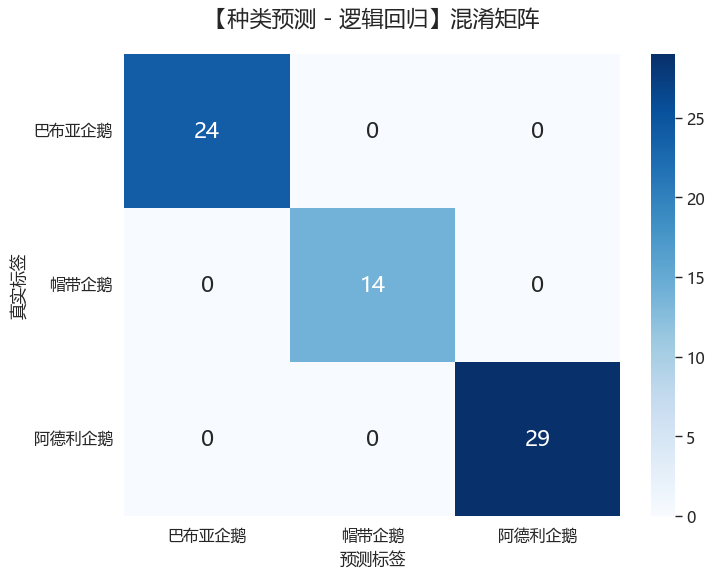


3. 特征重要性

特征重要性:
          特征       重要性
0    喙长 (mm)  1.280354
4       喙长宽比  0.977803
1    喙深 (mm)  0.791586
7    性别 (编码)  0.604971
2  鳍状肢长 (mm)  0.573671
3     体重 (g)  0.460854
5    体重 (kg)  0.460854
6    岛屿 (编码)  0.424997


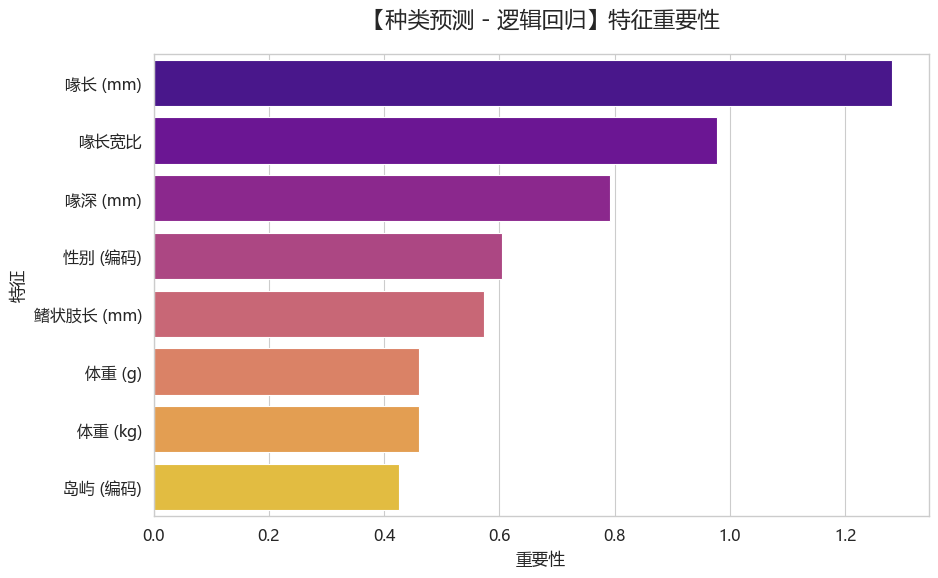

In [126]:
species_results = []

# 1. 逻辑回归
model_logreg = LogisticRegression(max_iter=2000, random_state=42)
param_logreg = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs']
}
res_logreg_s = train_evaluate_model(
    model_logreg, param_logreg,
    X_train_s, y_train_s, X_test_s, y_test_s,
    feature_cols_species, species_labels_zh,
    "种类预测 - 逻辑回归",
    feature_name_map_zh
)
species_results.append(res_logreg_s)

开始处理: 【种类预测 - 决策树】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'criterion': 'gini', 'max_depth': 3}
最佳10折交叉验证准确率: 0.9774

2. 测试集最终评估
测试集准确率: 1.0000

分类报告:
              precision    recall  f1-score   support

       巴布亚企鹅       1.00      1.00      1.00        24
        帽带企鹅       1.00      1.00      1.00        14
       阿德利企鹅       1.00      1.00      1.00        29

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



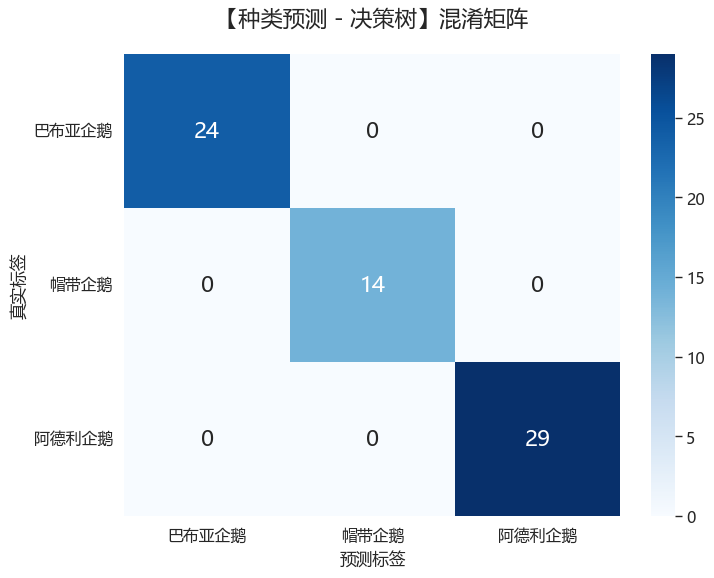


3. 特征重要性

特征重要性:
          特征       重要性
4       喙长宽比  0.568204
6    岛屿 (编码)  0.386198
7    性别 (编码)  0.023578
0    喙长 (mm)  0.022020
3     体重 (g)  0.000000
2  鳍状肢长 (mm)  0.000000
1    喙深 (mm)  0.000000
5    体重 (kg)  0.000000


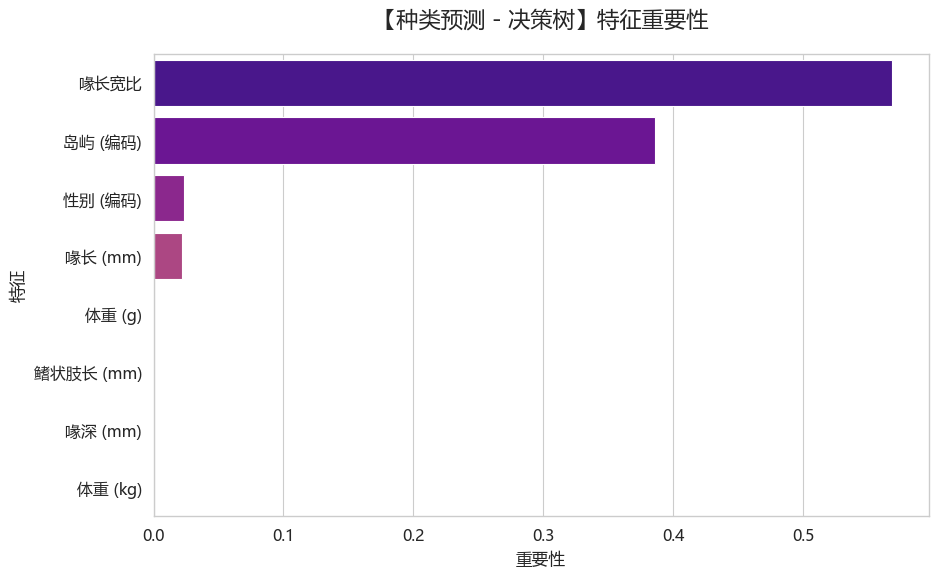

In [127]:
# 2. 决策树
model_dt = DecisionTreeClassifier(random_state=42)
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None]
}
res_dt_s = train_evaluate_model(
    model_dt, param_dt,
    X_train_s, y_train_s, X_test_s, y_test_s,
    feature_cols_species, species_labels_zh,
    "种类预测 - 决策树",
    feature_name_map_zh
)
species_results.append(res_dt_s)


开始处理: 【种类预测 - 随机森林】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}
最佳10折交叉验证准确率: 0.9811

2. 测试集最终评估
测试集准确率: 1.0000

分类报告:
              precision    recall  f1-score   support

       巴布亚企鹅       1.00      1.00      1.00        24
        帽带企鹅       1.00      1.00      1.00        14
       阿德利企鹅       1.00      1.00      1.00        29

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



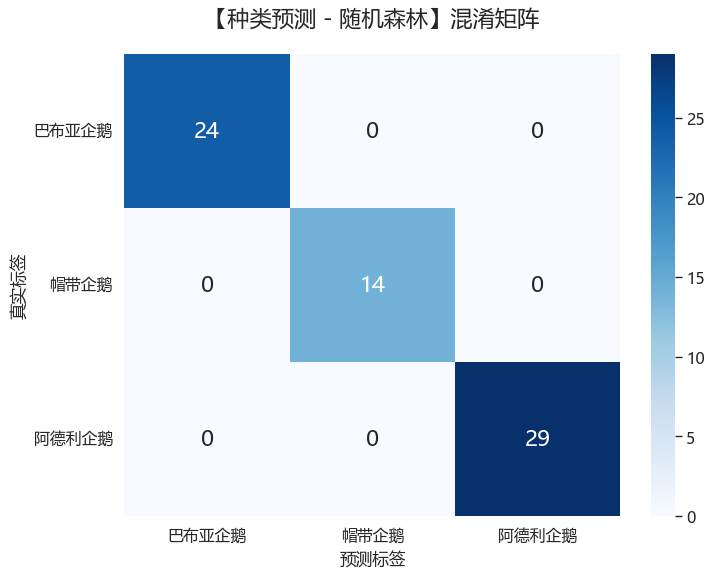


3. 特征重要性

特征重要性:
          特征       重要性
2  鳍状肢长 (mm)  0.245165
4       喙长宽比  0.237690
0    喙长 (mm)  0.192742
1    喙深 (mm)  0.122422
5    体重 (kg)  0.080048
6    岛屿 (编码)  0.065542
3     体重 (g)  0.051771
7    性别 (编码)  0.004620


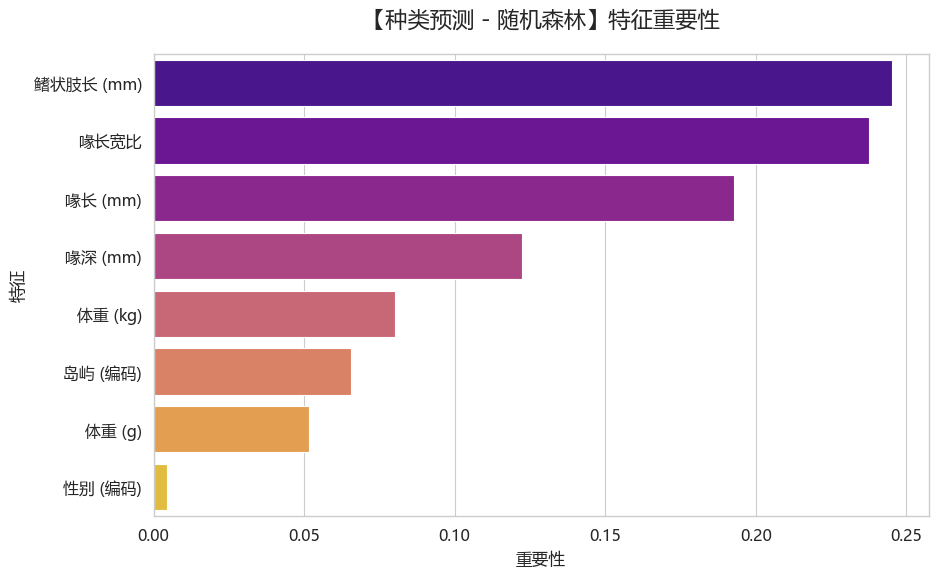

In [128]:
# 3. 随机森林
model_rf = RandomForestClassifier(random_state=42)
param_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'criterion': ['gini', 'entropy']
}
res_rf_s = train_evaluate_model(
    model_rf, param_rf,
    X_train_s, y_train_s, X_test_s, y_test_s,
    feature_cols_species, species_labels_zh,
    "种类预测 - 随机森林",
    feature_name_map_zh
)
species_results.append(res_rf_s)

开始处理: 【种类预测 - XGBoost】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
最佳10折交叉验证准确率: 0.9813

2. 测试集最终评估
测试集准确率: 1.0000

分类报告:
              precision    recall  f1-score   support

       巴布亚企鹅       1.00      1.00      1.00        24
        帽带企鹅       1.00      1.00      1.00        14
       阿德利企鹅       1.00      1.00      1.00        29

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



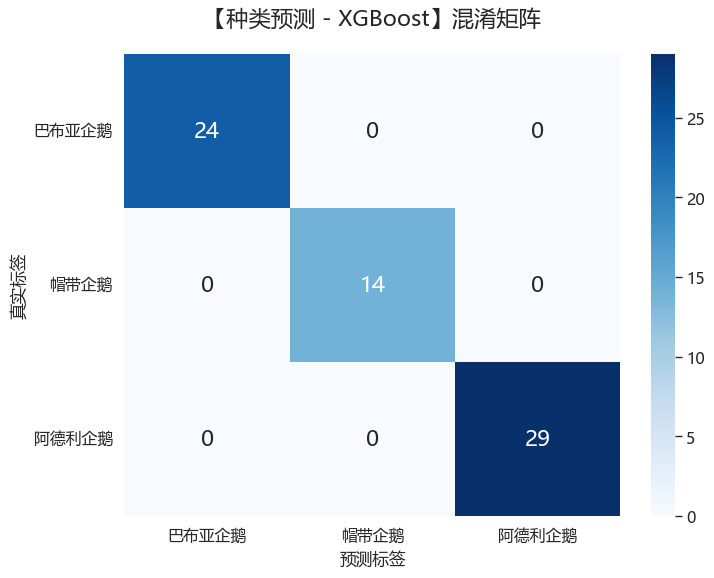


3. 特征重要性

特征重要性:
          特征       重要性
2  鳍状肢长 (mm)  0.422438
4       喙长宽比  0.412772
6    岛屿 (编码)  0.091788
1    喙深 (mm)  0.031082
7    性别 (编码)  0.016447
0    喙长 (mm)  0.013691
3     体重 (g)  0.011782
5    体重 (kg)  0.000000


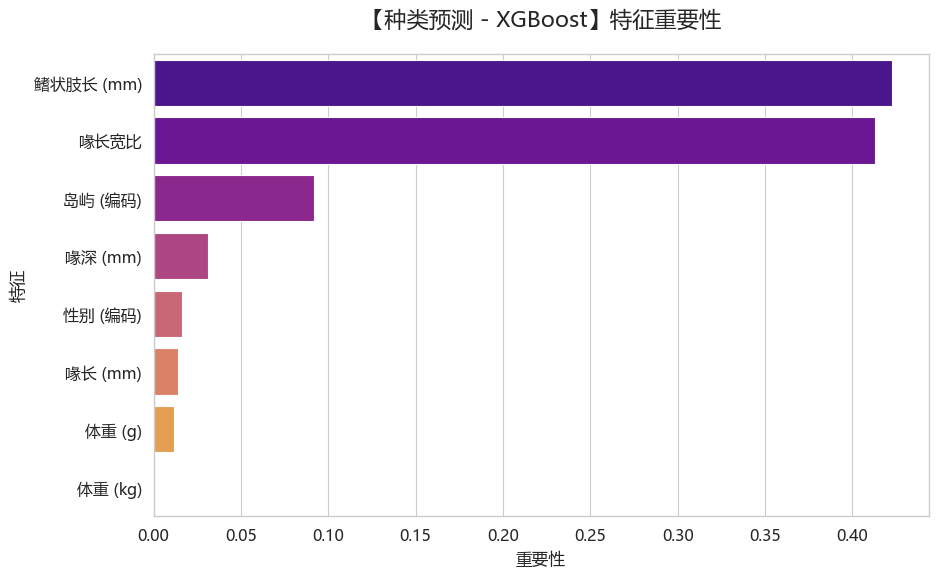

In [129]:
# 4. XGBoost
if XGB_IMPORTED:
    model_xgb = XGBClassifier(random_state=42, eval_metric='mlogloss') # mlogloss 用于多分类
    param_xgb = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    res_xgb_s = train_evaluate_model(
        model_xgb, param_xgb,
        X_train_s, y_train_s, X_test_s, y_test_s,
        feature_cols_species, species_labels_zh,
        "种类预测 - XGBoost",
        feature_name_map_zh
    )
    species_results.append(res_xgb_s)

# 执行模型：性别预测

开始处理: 【性别预测 - 逻辑回归】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'C': 1.0, 'solver': 'lbfgs'}
最佳10折交叉验证准确率: 0.9095

2. 测试集最终评估
测试集准确率: 0.8955

分类报告:
              precision    recall  f1-score   support

         女企鹅       0.93      0.85      0.89        33
         男企鹅       0.86      0.94      0.90        34

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.90        67
weighted avg       0.90      0.90      0.90        67



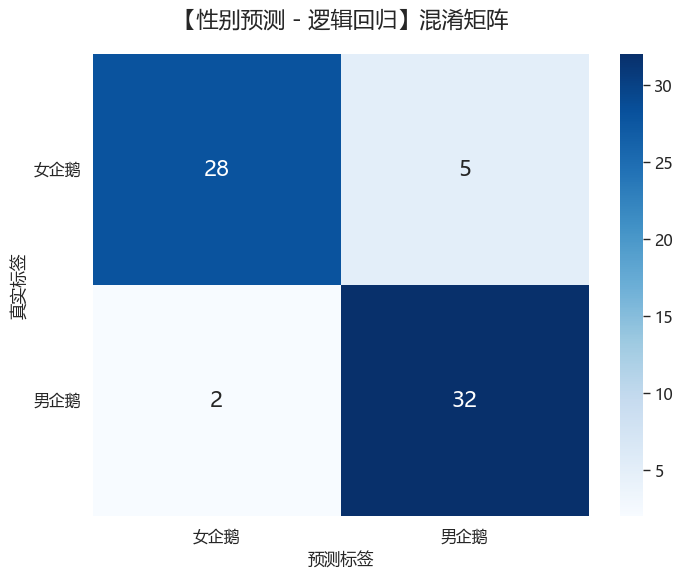


3. 特征重要性

特征重要性:
          特征       重要性
1    喙深 (mm)  2.308533
7    种类 (编码)  2.106731
3     体重 (g)  1.883795
5    体重 (kg)  1.883795
0    喙长 (mm)  1.525807
4       喙长宽比  0.625597
2  鳍状肢长 (mm)  0.311431
6    岛屿 (编码)  0.307443


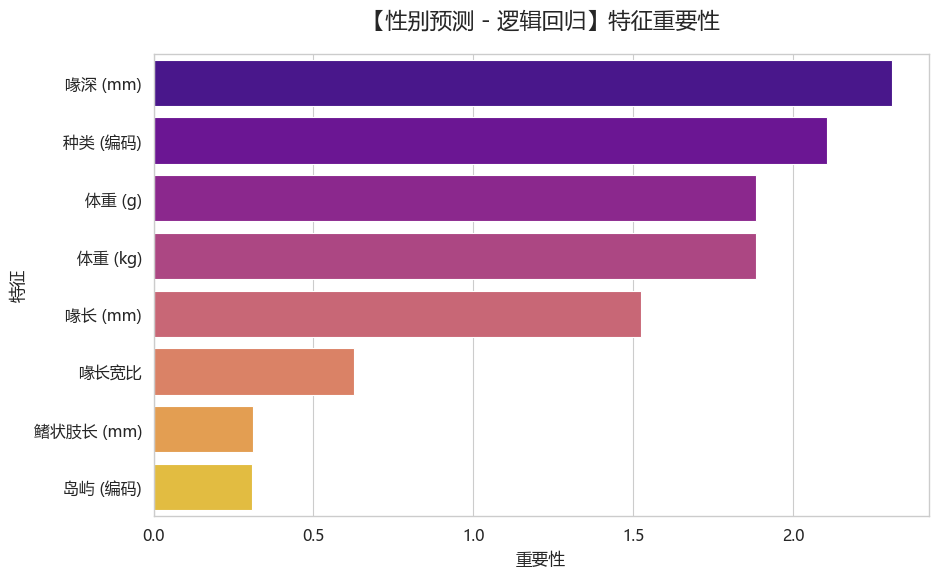

In [130]:
sex_results = []

# 1. 逻辑回归
res_logreg_x = train_evaluate_model(
    model_logreg, param_logreg,
    X_train_x, y_train_x, X_test_x, y_test_x,
    feature_cols_sex, sex_labels_zh,
    "性别预测 - 逻辑回归",
    feature_name_map_zh
)
sex_results.append(res_logreg_x)

开始处理: 【性别预测 - 决策树】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'criterion': 'gini', 'max_depth': 3}
最佳10折交叉验证准确率: 0.9095

2. 测试集最终评估
测试集准确率: 0.8358

分类报告:
              precision    recall  f1-score   support

         女企鹅       0.92      0.73      0.81        33
         男企鹅       0.78      0.94      0.85        34

    accuracy                           0.84        67
   macro avg       0.85      0.83      0.83        67
weighted avg       0.85      0.84      0.83        67



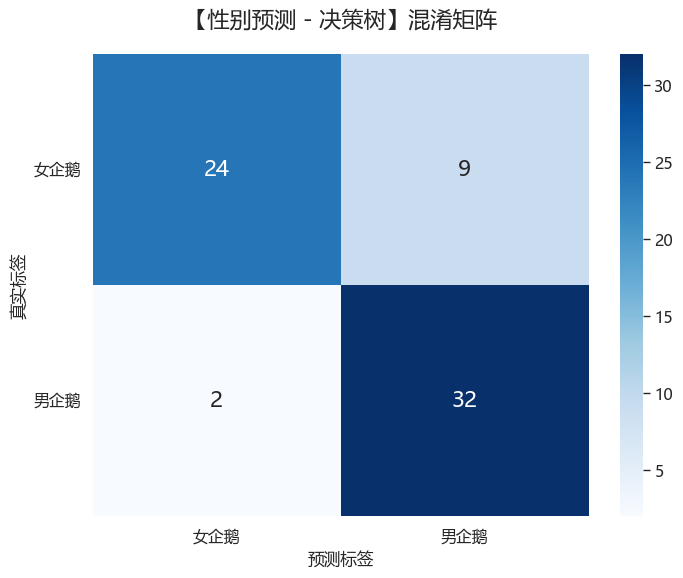


3. 特征重要性

特征重要性:
          特征       重要性
1    喙深 (mm)  0.543573
3     体重 (g)  0.280786
0    喙长 (mm)  0.105483
5    体重 (kg)  0.069614
4       喙长宽比  0.000544
2  鳍状肢长 (mm)  0.000000
6    岛屿 (编码)  0.000000
7    种类 (编码)  0.000000


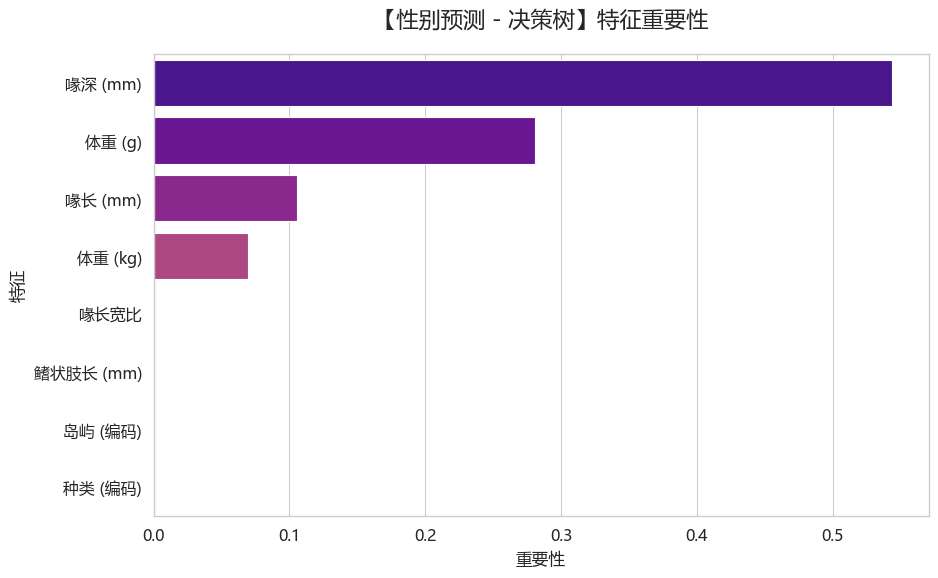

In [131]:
# 2. 决策树
res_dt_x = train_evaluate_model(
    model_dt, param_dt,
    X_train_x, y_train_x, X_test_x, y_test_x,
    feature_cols_sex, sex_labels_zh,
    "性别预测 - 决策树",
    feature_name_map_zh
)
sex_results.append(res_dt_x)

开始处理: 【性别预测 - 随机森林】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
最佳10折交叉验证准确率: 0.9172

2. 测试集最终评估
测试集准确率: 0.8955

分类报告:
              precision    recall  f1-score   support

         女企鹅       0.93      0.85      0.89        33
         男企鹅       0.86      0.94      0.90        34

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.90        67
weighted avg       0.90      0.90      0.90        67



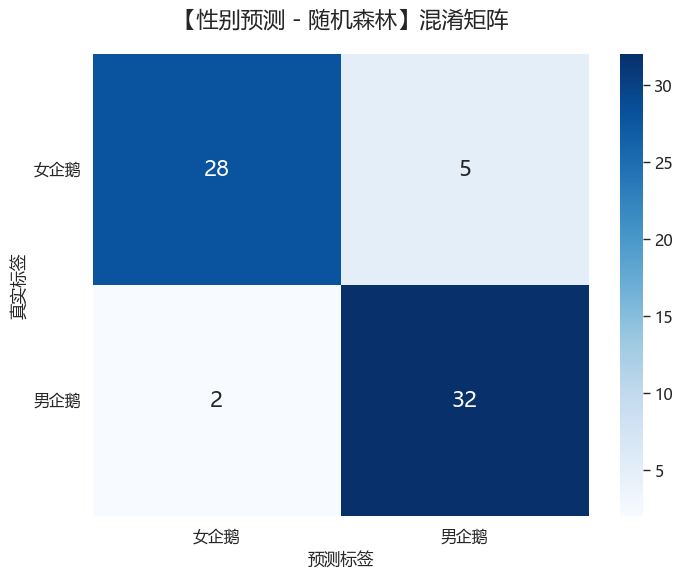


3. 特征重要性

特征重要性:
          特征       重要性
1    喙深 (mm)  0.259317
5    体重 (kg)  0.202208
3     体重 (g)  0.168724
0    喙长 (mm)  0.158691
4       喙长宽比  0.078708
2  鳍状肢长 (mm)  0.077647
7    种类 (编码)  0.036402
6    岛屿 (编码)  0.018302


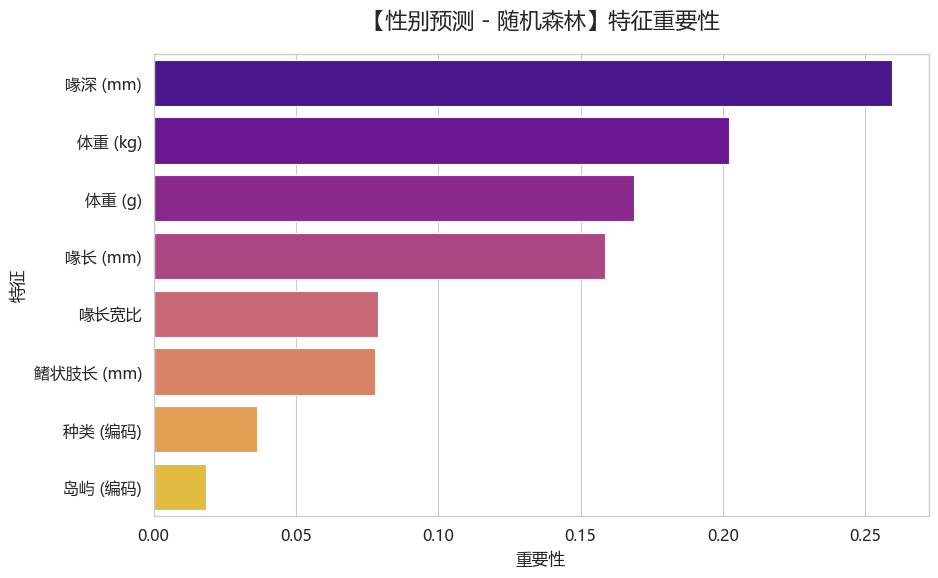

In [132]:
# 3. 随机森林
res_rf_x = train_evaluate_model(
    model_rf, param_rf,
    X_train_x, y_train_x, X_test_x, y_test_x,
    feature_cols_sex, sex_labels_zh,
    "性别预测 - 随机森林",
    feature_name_map_zh
)
sex_results.append(res_rf_x)

开始处理: 【性别预测 - XGBoost】
开始10折交叉验证调优

1. 交叉验证与调优结果 
最佳参数: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
最佳10折交叉验证准确率: 0.9470

2. 测试集最终评估
测试集准确率: 0.8507

分类报告:
              precision    recall  f1-score   support

         女企鹅       0.96      0.73      0.83        33
         男企鹅       0.79      0.97      0.87        34

    accuracy                           0.85        67
   macro avg       0.87      0.85      0.85        67
weighted avg       0.87      0.85      0.85        67



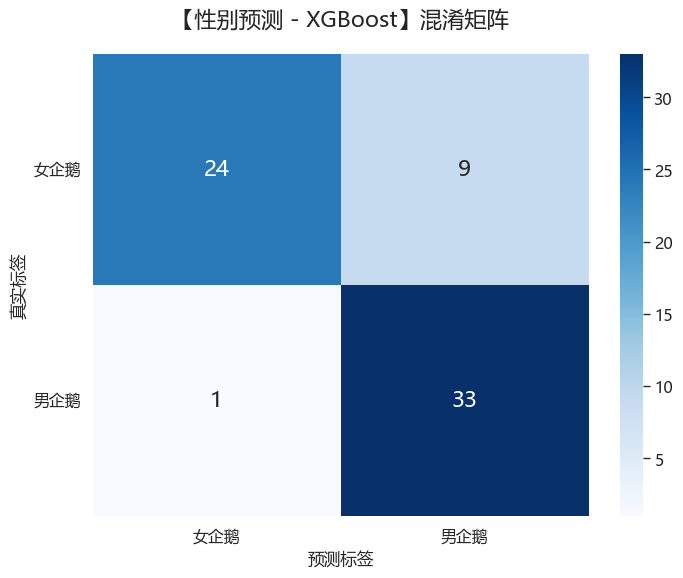


3. 特征重要性

特征重要性:
          特征       重要性
1    喙深 (mm)  0.318877
3     体重 (g)  0.253656
0    喙长 (mm)  0.161350
7    种类 (编码)  0.126736
4       喙长宽比  0.061728
2  鳍状肢长 (mm)  0.047277
6    岛屿 (编码)  0.030377
5    体重 (kg)  0.000000


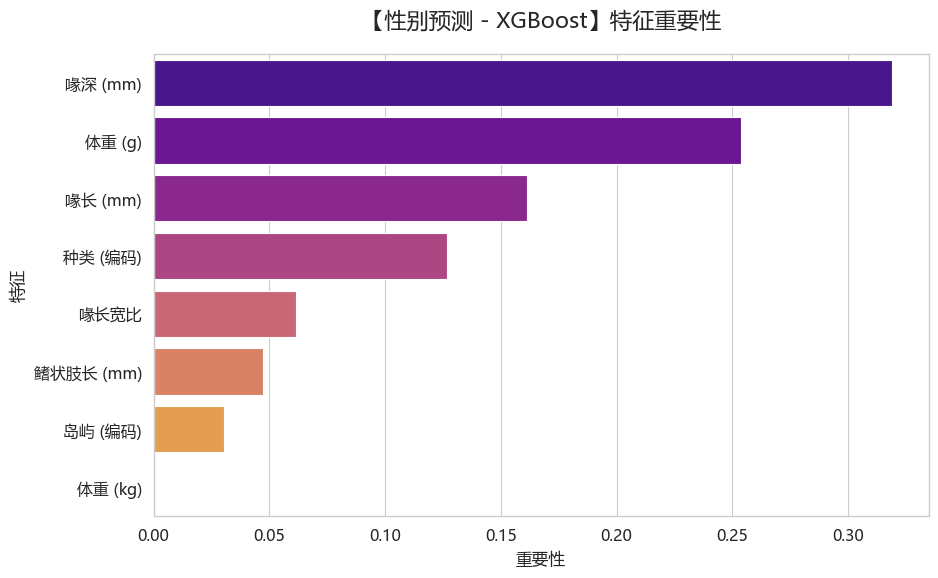

In [133]:
# 4. XGBoost
if XGB_IMPORTED:
    model_xgb_sex = XGBClassifier(random_state=42, eval_metric='logloss')  # logloss 用于二分类
    param_xgb_sex = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    res_xgb_x = train_evaluate_model(
        model_xgb_sex, param_xgb_sex,
        X_train_x, y_train_x, X_test_x, y_test_x,
        feature_cols_sex, sex_labels_zh,
        "性别预测 - XGBoost",
        feature_name_map_zh
    )
    sex_results.append(res_xgb_x)


# 模型对比汇总图

 种类预测结果汇总
        模型    任务  最佳10折CV准确率  测试集准确率
0     逻辑回归  种类预测      0.9925     1.0
1      决策树  种类预测      0.9774     1.0
2     随机森林  种类预测      0.9811     1.0
3  XGBoost  种类预测      0.9813     1.0

性别预测结果汇总
        模型    任务  最佳10折CV准确率  测试集准确率
0     逻辑回归  性别预测      0.9095  0.8955
1      决策树  性别预测      0.9095  0.8358
2     随机森林  性别预测      0.9172  0.8955
3  XGBoost  性别预测      0.9470  0.8507


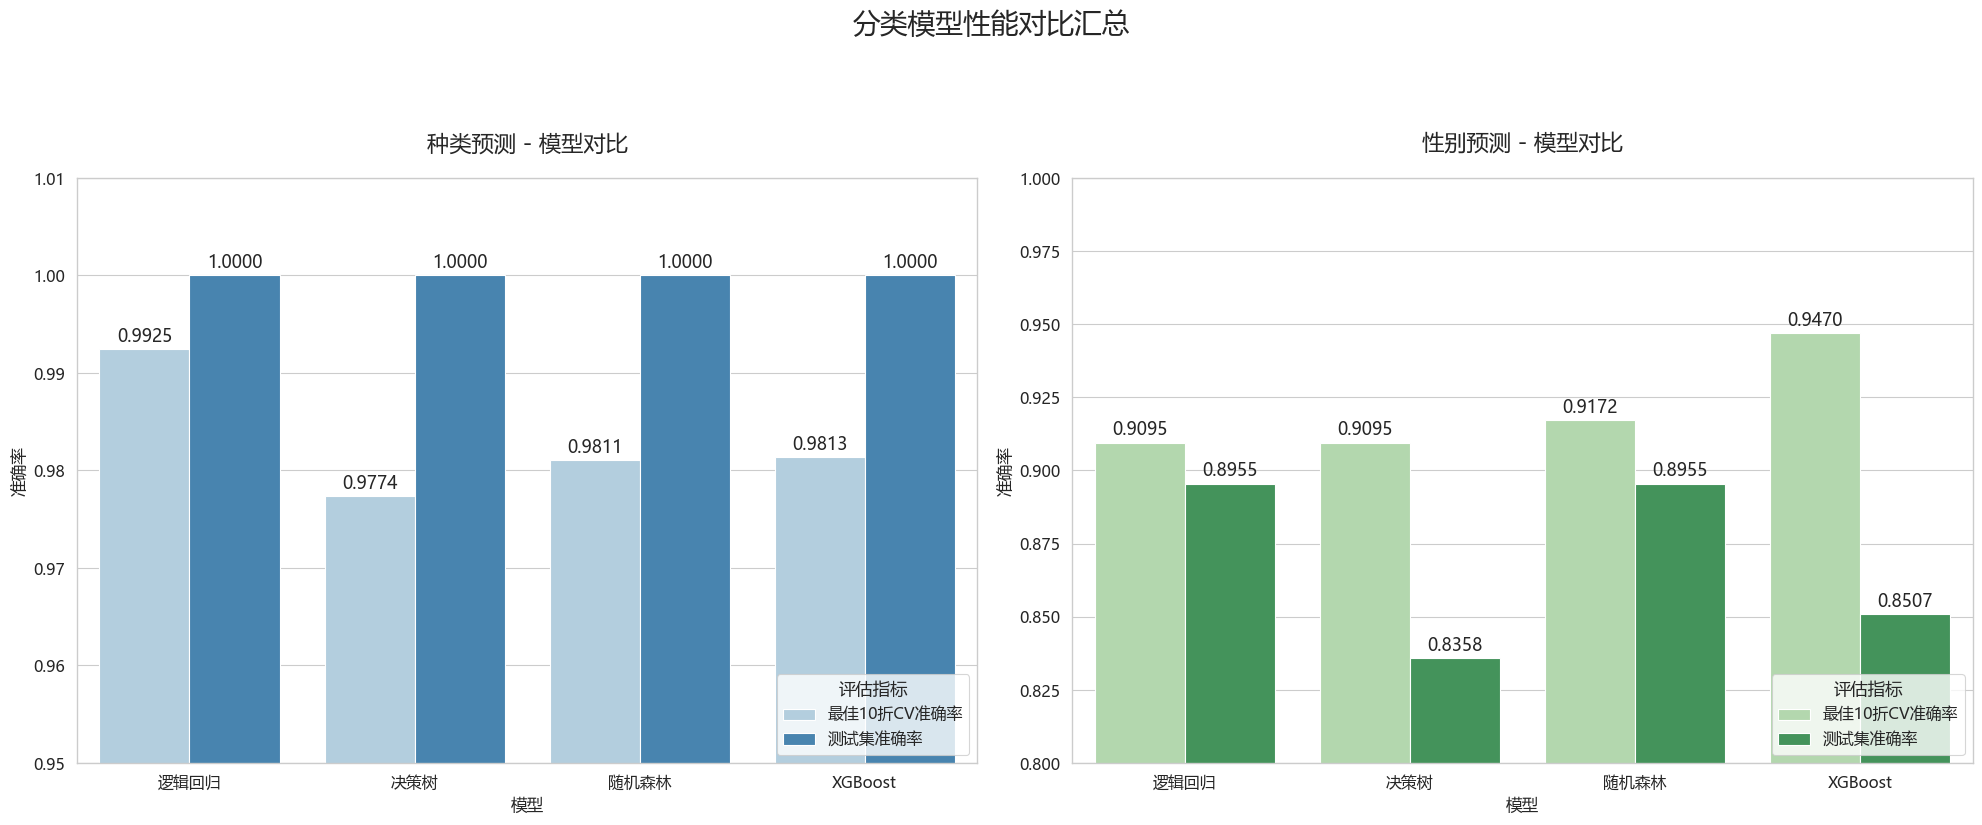

In [134]:
# 1. 转换结果为 DataFrame
df_species_results = pd.DataFrame(species_results)
df_sex_results = pd.DataFrame(sex_results)

print(" 种类预测结果汇总")
print(df_species_results.round(4))
print("\n性别预测结果汇总")
print(df_sex_results.round(4))

# 2. 准备用于绘图的数据 (使用 pd.melt)
df_species_melt = df_species_results.melt(
    id_vars=['模型'],
    value_vars=['最佳10折CV准确率', '测试集准确率'],
    var_name='评估指标',
    value_name='准确率'
)
df_sex_melt = df_sex_results.melt(
    id_vars=['模型'],
    value_vars=['最佳10折CV准确率', '测试集准确率'],
    var_name='评估指标',
    value_name='准确率'
)

# 3. 绘制对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # 1行2列
fig.suptitle('分类模型性能对比汇总', fontsize=20, y=1.03)

# 子图 1: 种类预测
sns.barplot(
    data=df_species_melt,
    x='模型',
    y='准确率',
    hue='评估指标',
    palette='Blues',
    ax=ax1
)
ax1.set_title('种类预测 - 模型对比', fontsize=16, pad=20)
ax1.set_xlabel('模型', fontsize=12)
ax1.set_ylabel('准确率', fontsize=12)
ax1.set_ylim(0.95, 1.01)  # 放大高分区域
ax1.legend(title='评估指标', loc='lower right')
# 在条形图上添加准确率数字
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

# 子图 2: 性别预测
sns.barplot(
    data=df_sex_melt,
    x='模型',
    y='准确率',
    hue='评估指标',
    palette='Greens',
    ax=ax2
)
ax2.set_title('性别预测 - 模型对比', fontsize=16, pad=20)
ax2.set_xlabel('模型', fontsize=12)
ax2.set_ylabel('准确率', fontsize=12)
ax2.set_ylim(0.80, 1.0)  # 放大高分区域
ax2.legend(title='评估指标', loc='lower right')
# 在条形图上添加准确率数字
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

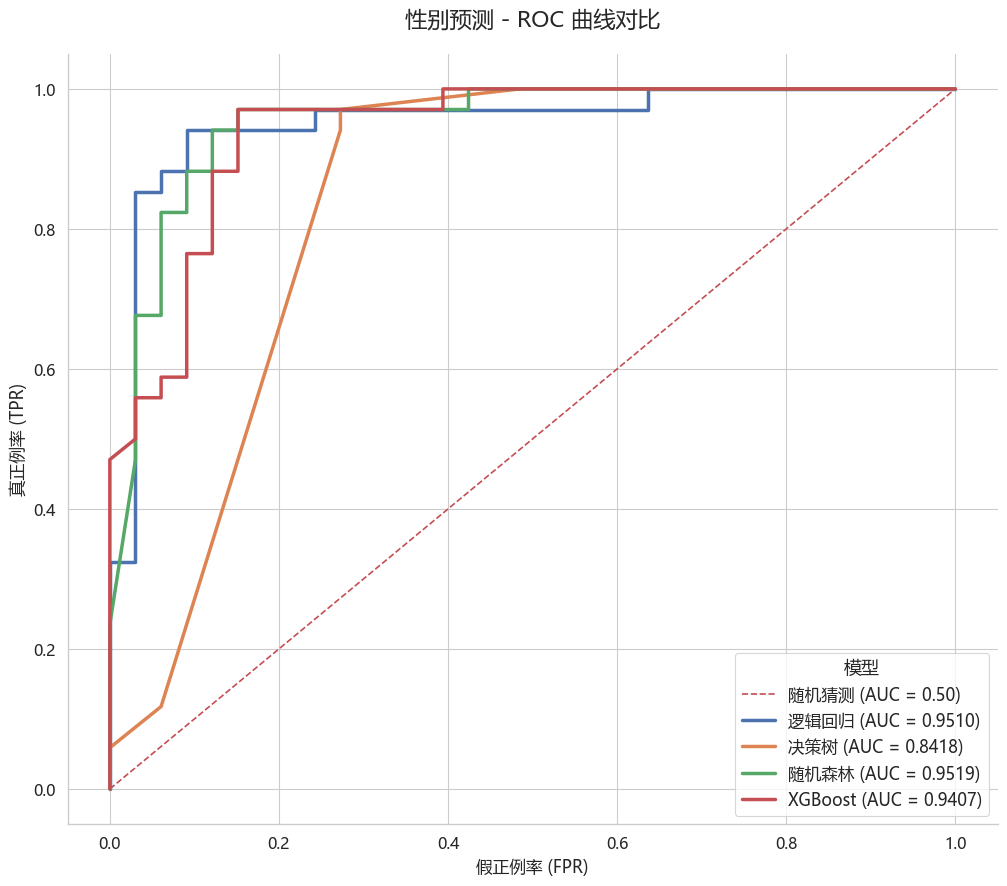

In [135]:
# ROC 曲线与 AUC 值对比（性别预测）
# 导入ROC曲线和AUC计算所需的库
from sklearn.metrics import roc_curve, auc

# 1. 准备一个字典来存储所有模型
# 我们在这里重新初始化模型，并使用上面GridSearchCV找到的“最佳参数”
models_to_plot = {}

# 逻辑回归 (使用 'lbfgs' 支持 predict_proba)
# 最佳参数: {'C': 1.0, 'solver': 'lbfgs'}
lr_best = LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000, random_state=42)
lr_best.fit(X_train_x, y_train_x)
models_to_plot['逻辑回归'] = lr_best

# 决策树
# 最佳参数: {'criterion': 'gini', 'max_depth': 3}
dt_best = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
dt_best.fit(X_train_x, y_train_x)
models_to_plot['决策树'] = dt_best

# 随机森林
# 最佳参数: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
rf_best = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100, random_state=42)
rf_best.fit(X_train_x, y_train_x)
models_to_plot['随机森林'] = rf_best

# XGBoost
# 检查 'XGB_IMPORTED' 是否存在且为 True
if 'XGB_IMPORTED' in locals() and XGB_IMPORTED:
    # 最佳参数: {''learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
    xgb_best = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=42, eval_metric='logloss')
    xgb_best.fit(X_train_x, y_train_x)
    models_to_plot['XGBoost'] = xgb_best

# 2. 绘制ROC曲线
plt.figure(figsize=(12, 10))
plt.title('性别预测 - ROC 曲线对比', fontsize=16, pad=20)

# 画一条 50% 准确率的“瞎猜”线
plt.plot([0, 1], [0, 1], 'r--', label='随机猜测 (AUC = 0.50)')

# 循环绘制每个模型的ROC曲线
for name, model in models_to_plot.items():
    # 获取模型预测为“正类”（ 1='男企鹅'）的概率
    # predict_proba 返回 [P(类别0), P(类别1)]，我们需要 P(类别1)
    y_pred_proba = model.predict_proba(X_test_x)[:, 1]

    # 计算 ROC 曲线的 x 和 y 坐标
    # y_test_x 是真实标签 (0或1), y_pred_proba 是预测为 1 的概率
    fpr, tpr, _ = roc_curve(y_test_x, y_pred_proba)

    # 计算曲线下面积 (AUC)
    roc_auc = auc(fpr, tpr)

    # 绘制曲线，并在图例中显示 AUC 值
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2.5)

plt.xlabel('假正例率 (FPR)', fontsize=12)
plt.ylabel('真正例率 (TPR)', fontsize=12)
plt.legend(title='模型', title_fontsize='13', loc='lower right', fontsize='12')
plt.grid(True)
sns.despine()
plt.show()

加载原始数据，可视化模型发现
正在绘制：种类预测 vs 8个特征


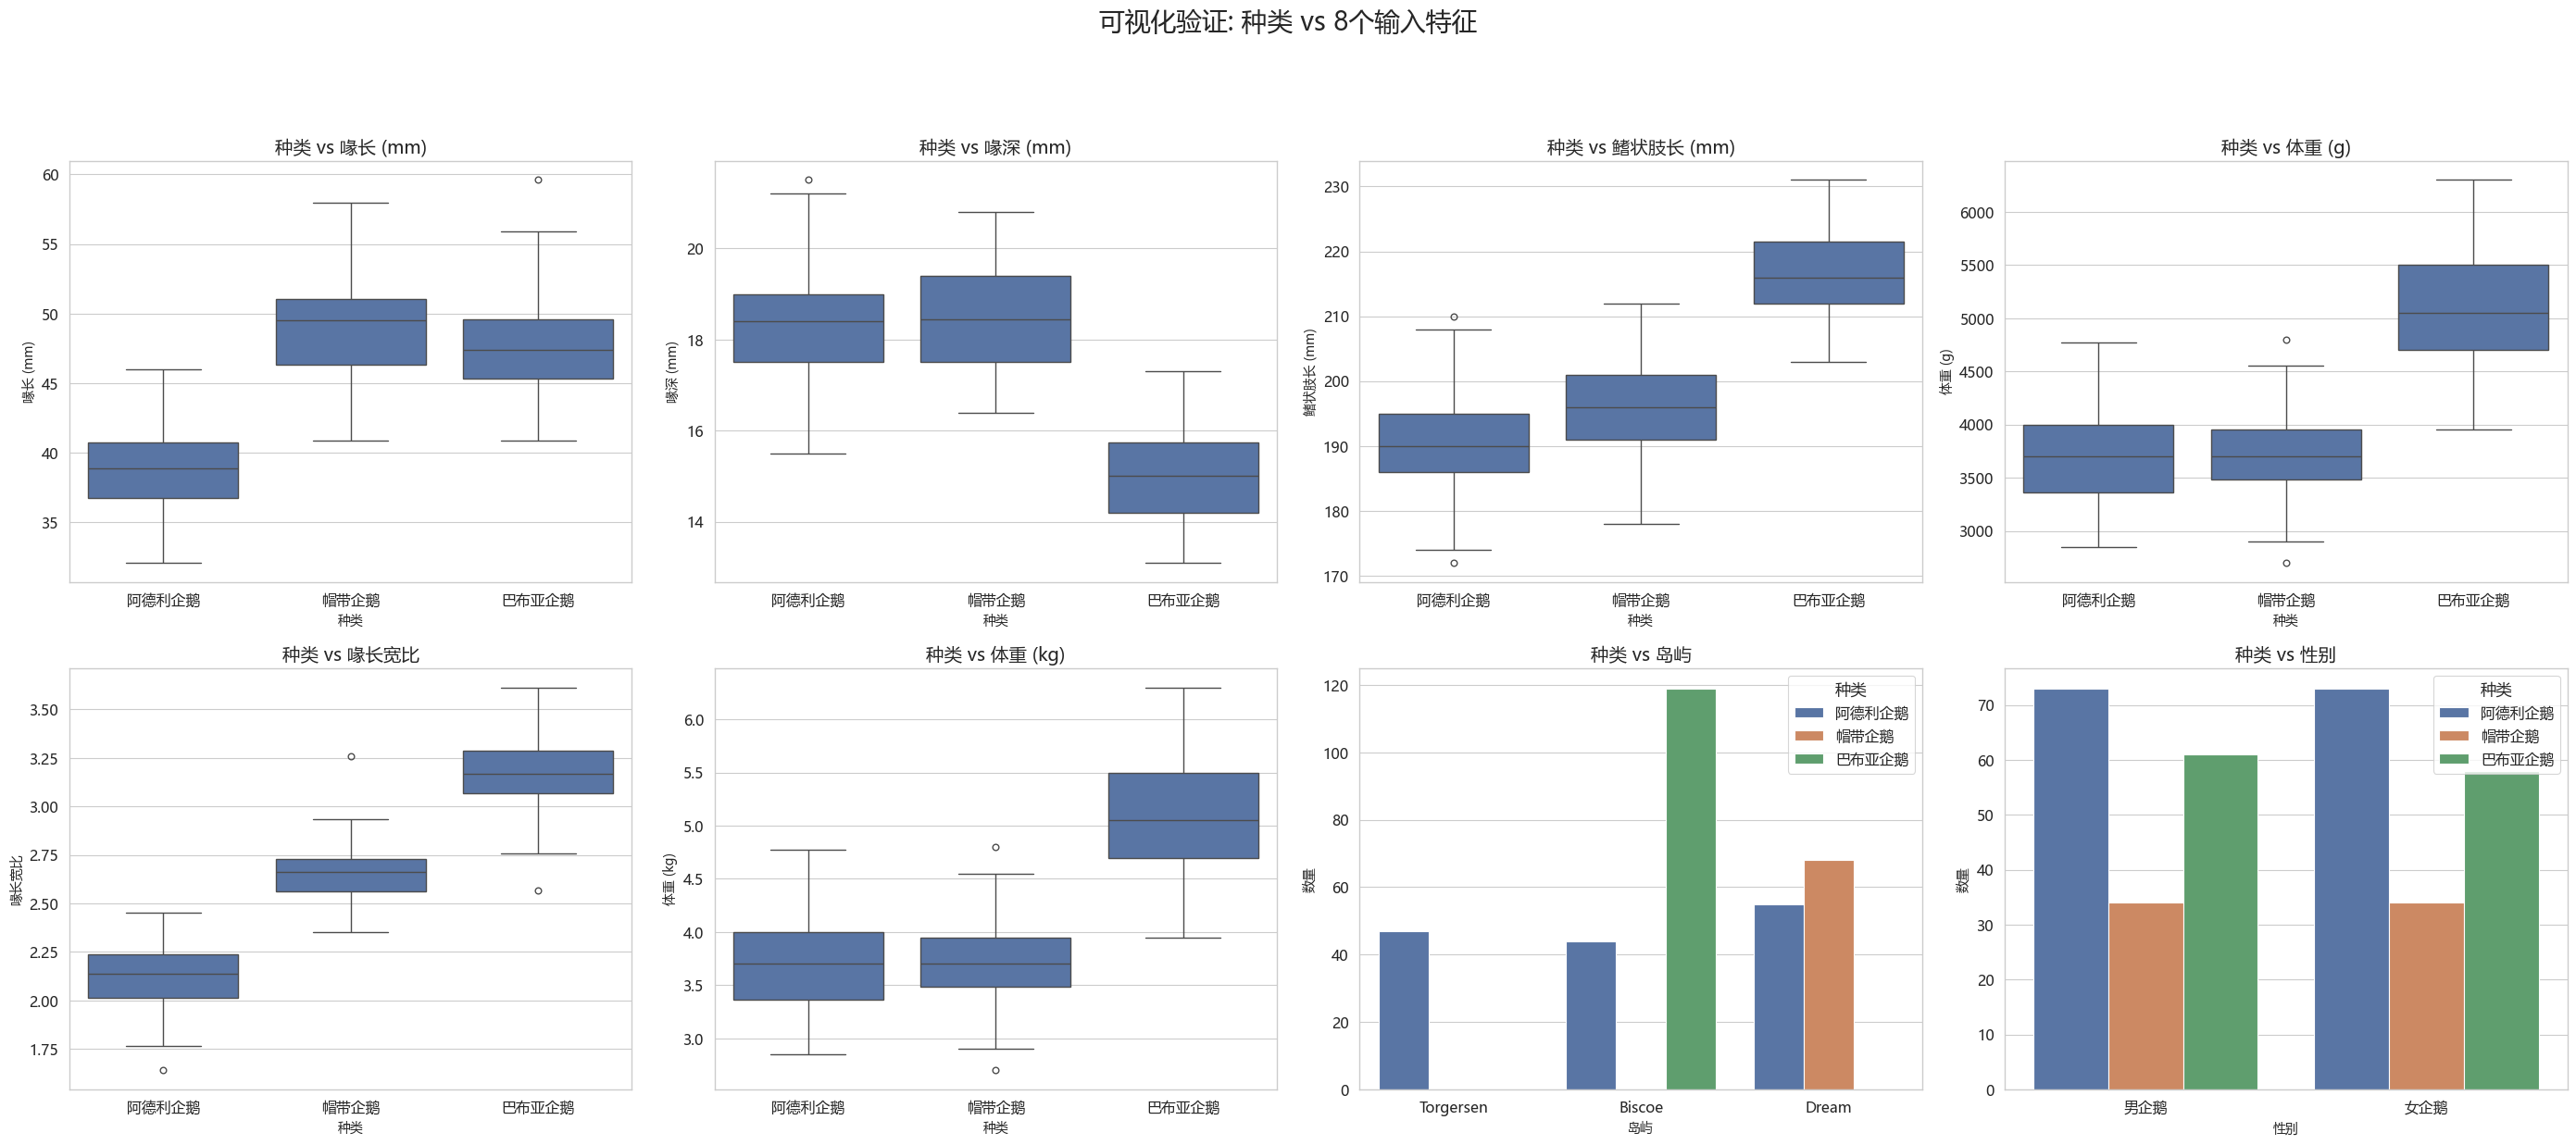


正在绘制：性别预测 vs 8个特征


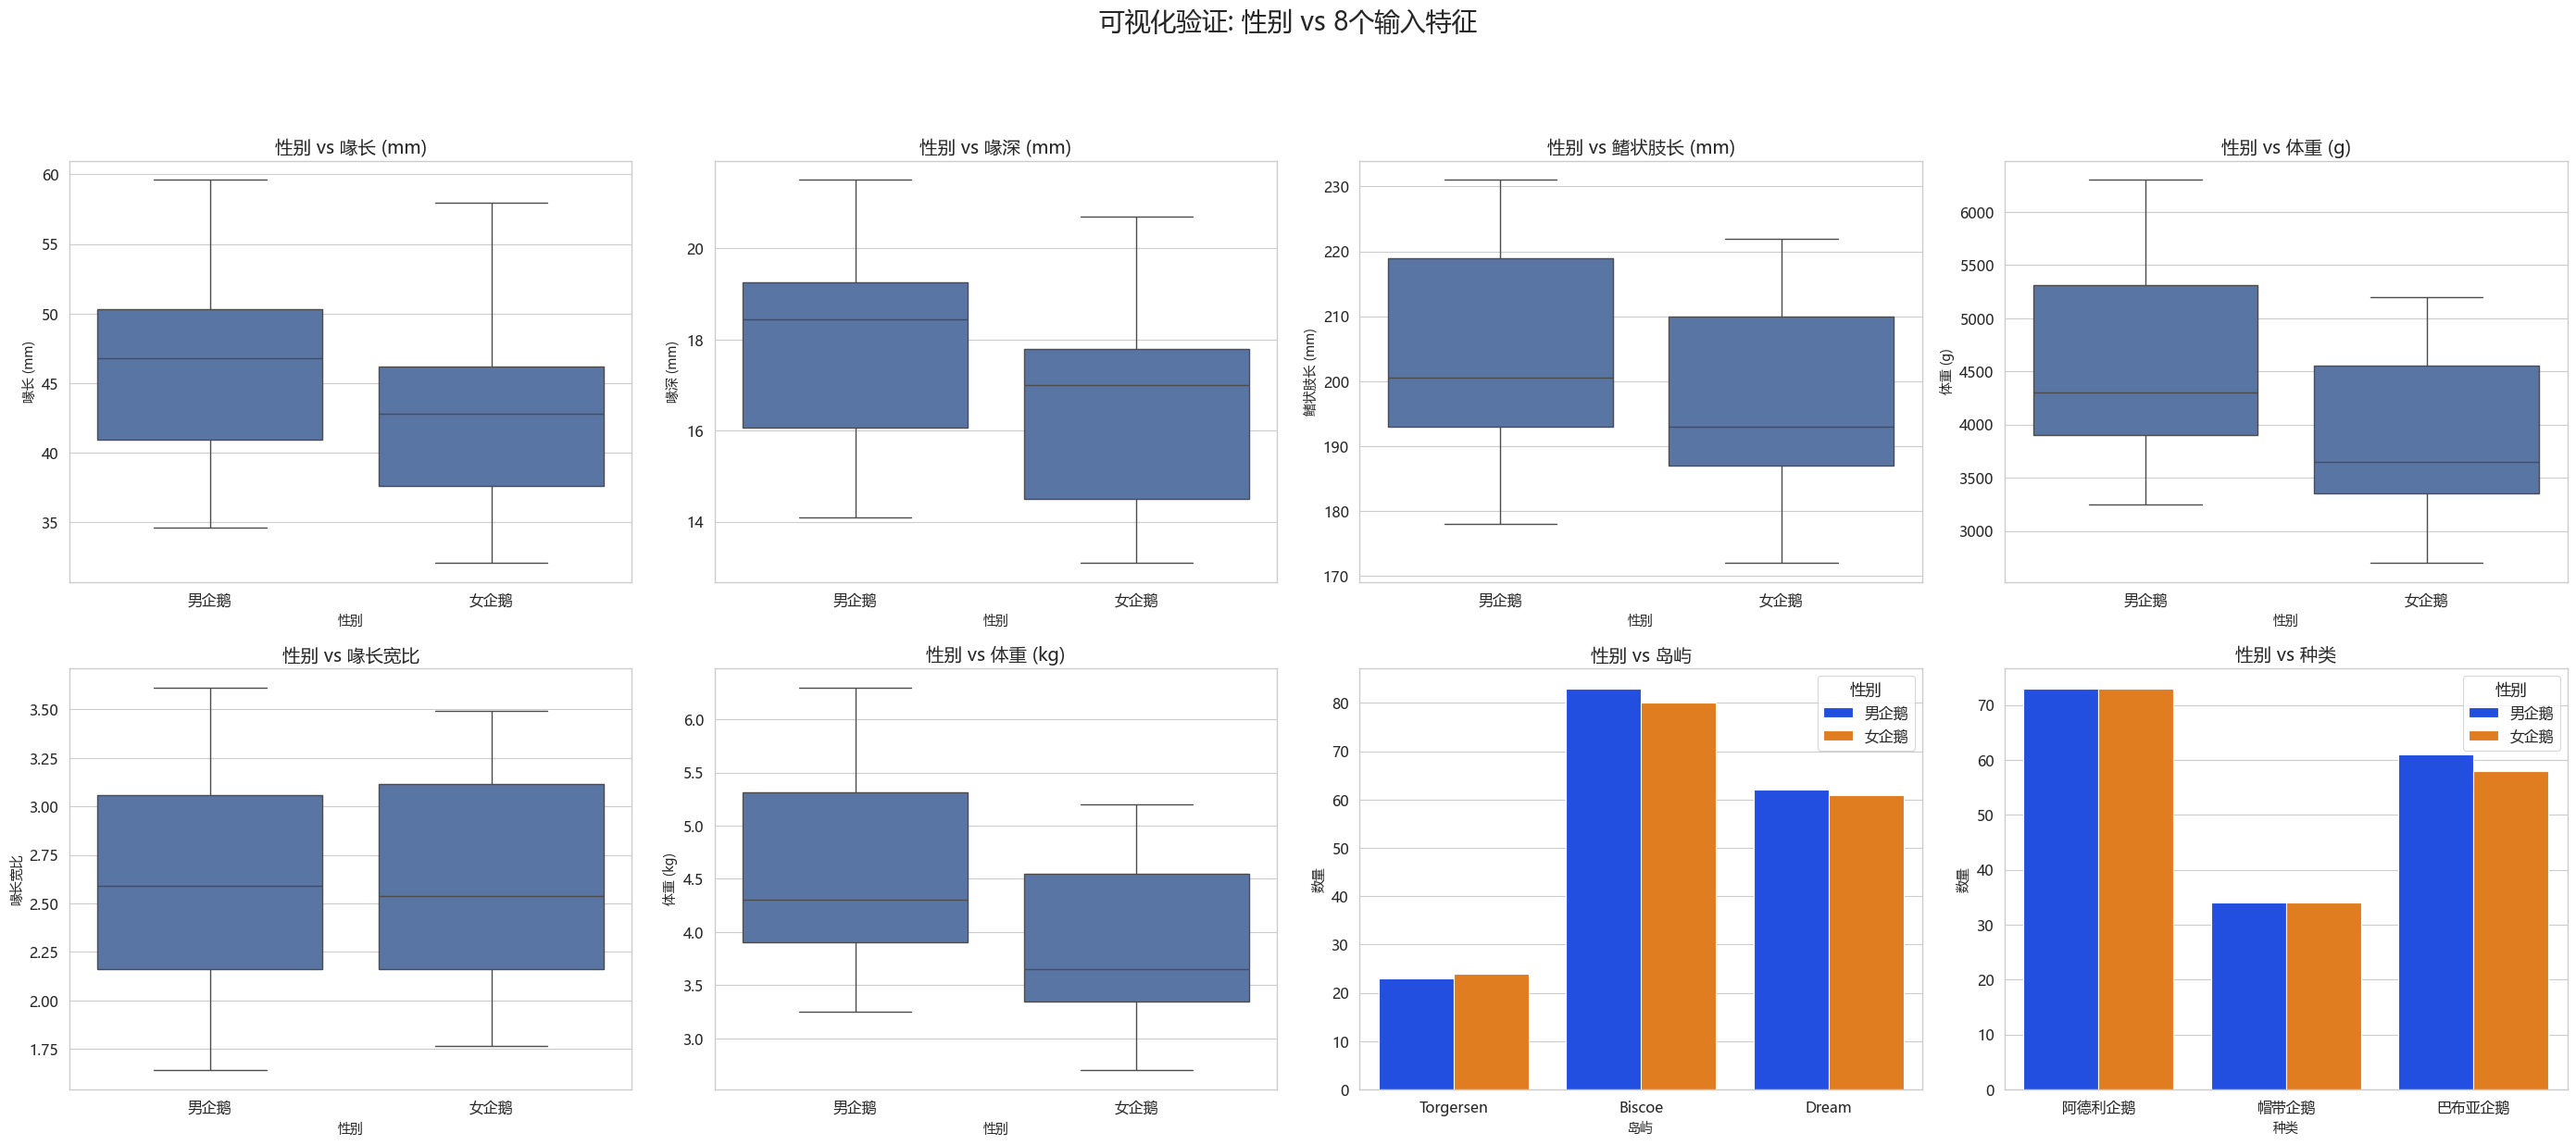

In [136]:
# 绘制特征与目标的箱线图

print("加载原始数据，可视化模型发现")
df_orig = pd.read_csv('penguins_size.csv')

# 2. 在内部重新执行“轻量化”清洗
df_orig = df_orig.dropna().copy()  # 去除缺失值
df_orig = df_orig[df_orig['sex'] != '.'].copy()  # 去除 '.' 异常值

# 3. 在内部重新添加“衍生特征”和“中文列”

feature_name_map_zh = {
    'culmen_length_mm': '喙长 (mm)',
    'culmen_depth_mm': '喙深 (mm)',
    'flipper_length_mm': '鳍状肢长 (mm)',
    'body_mass_g': '体重 (g)',
    'culmen_ratio': '喙长宽比',
    'body_mass_kg': '体重 (kg)',
    'island_encoded': '岛屿 (编码)',
    'sex_zh_encoded': '性别 (编码)',
    'species_zh_encoded': '种类 (编码)',
    'island': '岛屿',
    'sex_zh': '性别',
    'species_zh': '种类'
}
species_name_map = {
    'Adelie': '阿德利企鹅',
    'Chinstrap': '帽带企鹅',
    'Gentoo': '巴布亚企鹅'
}
sex_name_map = {
    'MALE': '男企鹅',
    'FEMALE': '女企鹅'
}


df_orig['culmen_ratio'] = df_orig['culmen_length_mm'] / df_orig['culmen_depth_mm']
df_orig['body_mass_kg'] = df_orig['body_mass_g'] / 1000
df_orig['species_zh'] = df_orig['species'].map(species_name_map)
df_orig['sex_zh'] = df_orig['sex'].map(sex_name_map)




if not df_orig.empty:

    # 2. 定义要检查的 8 个特征
    numeric_features = [
        'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
        'body_mass_g', 'culmen_ratio', 'body_mass_kg'
    ]
    # 2 个分类型特征 (用于种类预测)
    categorical_features_species = ['island', 'sex_zh']
    # 2 个分类型特征 (用于性别预测)
    categorical_features_sex = ['island', 'species_zh']

    # 3. 绘制 种类预测 的 8 个特征
    print("正在绘制：种类预测 vs 8个特征")
    fig_species, axes_species = plt.subplots(2, 4, figsize=(28, 12))  # 2行4列, 共8图
    fig_species.suptitle('可视化验证: 种类 vs 8个输入特征', fontsize=20, y=1.03)

    # 展平 axes 数组，方便循环
    axes_list = axes_species.flatten()

    # 绘制 6 个数值型特征 (箱线图)
    for i, feature in enumerate(numeric_features):
        sns.boxplot(ax=axes_list[i], data=df_orig, x='species_zh', y=feature)
        axes_list[i].set_title(f'种类 vs {feature_name_map_zh[feature]}', fontsize=14)
        axes_list[i].set_xlabel('种类', fontsize=10)
        axes_list[i].set_ylabel(feature_name_map_zh[feature], fontsize=10)

    # 绘制 2 个分类型特征 (柱状图)
    for i, feature in enumerate(categorical_features_species):
        ax_index = len(numeric_features) + i
        # 使用 countplot 并按 'species_zh' 拆分
        sns.countplot(ax=axes_list[ax_index], data=df_orig, x=feature, hue='species_zh', palette='deep')
        axes_list[ax_index].set_title(f'种类 vs {feature_name_map_zh[feature]}', fontsize=14)
        axes_list[ax_index].set_xlabel(feature_name_map_zh[feature], fontsize=10)
        axes_list[ax_index].set_ylabel('数量', fontsize=10)
        axes_list[ax_index].legend(title='种类')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # 4. 绘制 性别预测 的 8 个特征
    print("\n正在绘制：性别预测 vs 8个特征")
    fig_sex, axes_sex = plt.subplots(2, 4, figsize=(28, 12))  # 2行4列, 共8图
    fig_sex.suptitle('可视化验证: 性别 vs 8个输入特征', fontsize=20, y=1.03)

    # 展平 axes 数组
    axes_list = axes_sex.flatten()

    # 绘制 6 个数值型特征 (箱线图)
    for i, feature in enumerate(numeric_features):
        sns.boxplot(ax=axes_list[i], data=df_orig, x='sex_zh', y=feature)
        axes_list[i].set_title(f'性别 vs {feature_name_map_zh[feature]}', fontsize=14)
        axes_list[i].set_xlabel('性别', fontsize=10)
        axes_list[i].set_ylabel(feature_name_map_zh[feature], fontsize=10)

    # 绘制 2 个分类型特征 (柱状图)
    for i, feature in enumerate(categorical_features_sex):
        ax_index = len(numeric_features) + i
        sns.countplot(ax=axes_list[ax_index], data=df_orig, x=feature, hue='sex_zh', palette='bright')
        axes_list[ax_index].set_title(f'性别 vs {feature_name_map_zh[feature]}', fontsize=14)
        axes_list[ax_index].set_xlabel(feature_name_map_zh[feature], fontsize=10)
        axes_list[ax_index].set_ylabel('数量', fontsize=10)
        axes_list[ax_index].legend(title='性别')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("无法进行可视化验证，因为 'penguins_size.csv' 未加载。")